In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats

from root_to_np import get_tree, get_df, rename_tree_branches

Welcome to JupyROOT 6.26/04
END OF SCRIPT


In [2]:
run = [627,632]
pad_name = [37,38,27,28]
which_mcp = [1,1,2,2]
centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)

color = np.array(['red','blue','purple','green'])

In [3]:
def transfo(x,y,x0,y0, theta): #from sym to beam frame and vice versa
    dx=x-x0
    dy=y-y0
    return (dx*np.cos(theta)+dy*np.sin(theta), -dx*np.sin(theta)+dy*np.cos(theta))

cross_beam = [22.39996479308732, 25.69888050613195]
theta_beam = -1.0203e-02
theta_local=-theta_beam

In [4]:
data = []
for irun in run:
    tree = get_tree(irun)
    
    var_indexes = np.array([1,2,4,5,6,7])
    for index in range(4):
        var_indexes = np.append(var_indexes,[index*10+8,index*10+9,index*10+12,index*10+14,index*10+11]) 
    var_indexes = np.append(var_indexes,[67,65,66])
    
    data_single = get_df(tree,*var_indexes)
    
    old_names = ['mcp_gpeak','mcp_qall','mcp_t']
    new_names = ['mcp1_gpeak','mcp1_qall','mcp1_t']
    names = [old_names,new_names]
    data_single = rename_tree_branches(data_single,*names)
    
    print(len(data_single))
    data.append(data_single)

data = pd.concat(data,ignore_index=True)
print(data.head())
print(len(data))

['Pico;1']
['srs', 'mcp_gpeak', 'mcp_qall', 'mcp_tnaive', 'mcp_t', 'mcp2_gpeak', 'mcp2_qall', 'mcp2_t', 'mm1_gpeak', 'mm1_qall', 'mm1_tnaive', 'mm1_t', 'mm1_qe', 'mm1_pl3', 'mm1_qfit', 'mm1_xh', 'mm1_qh', 'mm1_gmin', 'mm2_gpeak', 'mm2_qall', 'mm2_tnaive', 'mm2_t', 'mm2_qe', 'mm2_pl3', 'mm2_qfit', 'mm2_xh', 'mm2_qh', 'mm2_gmin', 'mm3_gpeak', 'mm3_qall', 'mm3_tnaive', 'mm3_t', 'mm3_qe', 'mm3_pl3', 'mm3_qfit', 'mm3_xh', 'mm3_qh', 'mm3_gmin', 'mm4_gpeak', 'mm4_qall', 'mm4_tnaive', 'mm4_t', 'mm4_qe', 'mm4_pl3', 'mm4_qfit', 'mm4_xh', 'mm4_qh', 'mm4_gmin', 'nmm1_x', 'mm1_x', 'nmm1_y', 'mm1_y', 'nmm2_x', 'mm2_x', 'nmm2_y', 'mm2_y', 'nmm3_x', 'mm3_x', 'nmm3_y', 'mm3_y', 'nmm4_x', 'mm4_x', 'nmm4_y', 'mm4_y', 'ntracks', 'xy', 'chi2', 'track_flag', 'ndetsintrack', 'distnextcluster']
<Report start=0 stop=4564 source='/home/evridiki/Downloads/test_run627.root:/Pico;1'>
<Report start=4564 stop=9128 source='/home/evridiki/Downloads/test_run627.root:/Pico;1'>
<Report start=9128 stop=13692 source='/home

133500
   mcp1_gpeak  mcp1_qall      mcp1_t  mcp2_gpeak  mcp2_qall      mcp2_t  \
0    0.363840   4.079505  213.766425    0.388868   4.378314  210.756365   
1    0.283834   3.219750  216.168954    0.300563   3.428301  213.050217   
2    0.316077   3.690976  209.404572    0.332085   3.902691  206.369978   
3    0.323914   3.745984  214.868378    0.343686   3.937175  211.812731   
4    0.302096   3.402782  196.919885    0.321154   3.591632  193.894127   

   mm1_gpeak   mm1_qall     mm1_qe   mm1_qfit  ...  mm4_gpeak  mm4_qall  \
0   0.101771  24.178752   5.292243   4.160124  ...   0.005641 -0.229483   
1   0.016982   3.395602   0.630930   0.539677  ...   0.005778  0.000000   
2   0.371350  87.252027  19.667630  16.273460  ...   0.022988  0.270956   
3   0.103226  20.582476   4.708409   3.839707  ...   0.005587  0.359974   
4   0.106149  21.948278   4.651852   3.933427  ...   0.005552 -0.315675   

     mm4_qe  mm4_qfit       mm4_t  track_flag      xy[0]      xy[1]  xy[2]  \
0  0.008546  

In [5]:
#define the cuts
mm_basic_cut= []

mcp_overflow = np.logical_and((data.mcp1_gpeak>0.)*(data.mcp1_gpeak<=0.72),
                             (data.mcp2_gpeak>0.)*(data.mcp2_gpeak<=0.72))
chi2_cut = (data.track_flag>0)
mcp_basic_cut = mcp_overflow*chi2_cut

for index in range(4):
    pad = index+1
       
    mm_gpeak = f'mm{pad}_gpeak'
    mm_qall = f'mm{pad}_qall'
    mm_qe = f'mm{pad}_qe'
    mm_qfit = f'mm{pad}_qfit'
    mm_overflow = (data[mm_gpeak]>0.02)*(data[mm_gpeak]<0.36)*(data[mm_qall]>0)
    qe_line = (data[mm_qe]>30.*data[mm_gpeak])
    cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)
    cut = np.logical_and(mm_overflow,mcp_basic_cut)
                         
    mm_basic_cut.append(cut)

In [6]:
class SAT:
    def __init__(self, sat):
        self.sat = sat
    
    def GetAvrg(self,weights):
        avrg = np.average(self.sat,weights = weights)
        return avrg
    
    def GetWeightedStd(self,weights):
        variance = np.average((self.sat-self.GetAvrg(weights))**2, weights=weights)
        return np.sqrt(variance)
    
    def ReduceSAT(self,around=0, t_range=100):
        self.sat = self.sat[np.abs(self.sat- around)<= t_range] 
        
    def GetHist(self,bins=100):
        counts, edges = np.histogram(self.sat, bins =bins)
        bin_centers = (edges[1:]+edges[:-1])/2
        return counts, edges, bin_centers
        
    def PlotSAT(self,ax=plt, color='black',bins=100,label=''):
        c,_,b = self.GetHist(bins =bins)
        ax.errorbar(b, c, yerr=np.sqrt(c), fmt='o',markersize=4.,
                color=color,label= label)
        
    def PlotHist(self,ax=plt ,color='black',bins=100,label='',range=[]):
        if len(range)==0:
            range=[self.sat.min(),self.sat.max()]
        ax.hist(self.sat, bins =bins, range=range,
                            color = color, histtype='step',label = label)
        
    def FitSAT(self, f , p0,bins=100, param_bounds=([0.1,-np.inf,1,0.1,1],[np.inf,np.inf,np.inf,np.inf,np.inf])):
        if len(p0) != len(param_bounds[0]):
            print('ERROR!!! Check compatibility between parameters and their bounds')
            sys.exit(1)
            
        c,_,b = self.GetHist(bins =bins)
        popt, pcov = curve_fit(f, b, c, p0=p0, bounds = param_bounds)
        return popt

In [7]:
def double_gaus( x, *params ):
    (c1, mu, sigma1, c2, sigma2) = params
    res =   c1 * np.exp( - (x - mu)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu)**2.0 / (2.0 * sigma2**2.0) )
    return res
def simple_gaus(x,c,mu,sigma):
    res =   c * np.exp( - (x - mu)**2.0 / (2.0 * sigma**2.0) ) 
    return res
def double_sigma(x, *params):
    prob =  double_gaus(x,*params)/double_gaus(x,*params).sum()
    mu_double   = x.dot(prob)         # mean value
    mom2 = np.power(x, 2).dot(prob)  # 2nd moment
    var  = mom2 - mu_double**2        # variance
    sigma = np.sqrt(var) 
    return sigma

In [21]:
pad =4
index =pad-1
xc = centers_from_fit[0][index]
yc = centers_from_fit[1][index]
xc,yc = transfo(xc,yc,cross_beam[0],cross_beam[1],theta_local) #in local

mm_gpeak = f'mm{pad}_gpeak'
mm_qall = f'mm{pad}_qall'
mm_t = f'mm{pad}_t'
mcp_t=f'mcp{which_mcp[index]}_t'

In [22]:
#x,y,sat,sat_error, rms, rms_error
step = 2

pad_seed = np.empty((0,4))
sat_hist=[[None] * 5 for i in range(5)]

for i,xstep in enumerate(range(-5,5,step)):
    for j,ystep in enumerate(range(-5,5,step)):
        
        x0 =xc+xstep+1
        y0 = yc+ystep+1
        
        x = data.iloc[:,-4].values
        y = data.iloc[:,-3].values
        x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
        
        seed = np.logical_and(np.abs(x-x0)<step/2, 
                                           np.abs(y-y0)<step/2)
        mm_time_cut = mm_basic_cut[index]*seed
        
        sat = (data[mm_t][mm_time_cut] - data[mcp_t][mm_time_cut])*1000 #ps

        sat_hist[i][j] = SAT(sat)

        w = np.abs(1/(sat_hist[i][j].sat-sat_hist[i][j].sat.mean()))
        avrg,std = sat_hist[i][j].GetAvrg(w), sat_hist[i][j].GetWeightedStd(w)
    
        sat_hist[i][j].ReduceSAT(avrg,10*std) # to exclude times waaay out of range
        #and update
        avrg,std = sat_hist[i][j].sat.mean(), sat_hist[i][j].sat.std()
    
        g2_par = np.array([350.,avrg,10,50,30])
        g2_par =sat_hist[i][j].FitSAT(f = double_gaus,p0=g2_par)
        (c1, mu, sigma1, c2, sigma2) = g2_par
        
        x = np.linspace(mu-5*std,mu+5*std,2000)
        sigma_double = double_sigma(x,*g2_par)

        pad_seed = np.append(pad_seed,
                             np.array([[xstep, ystep, mu, sigma_double]]),
                            axis = 0)
        
pad_seed.shape

(25, 4)

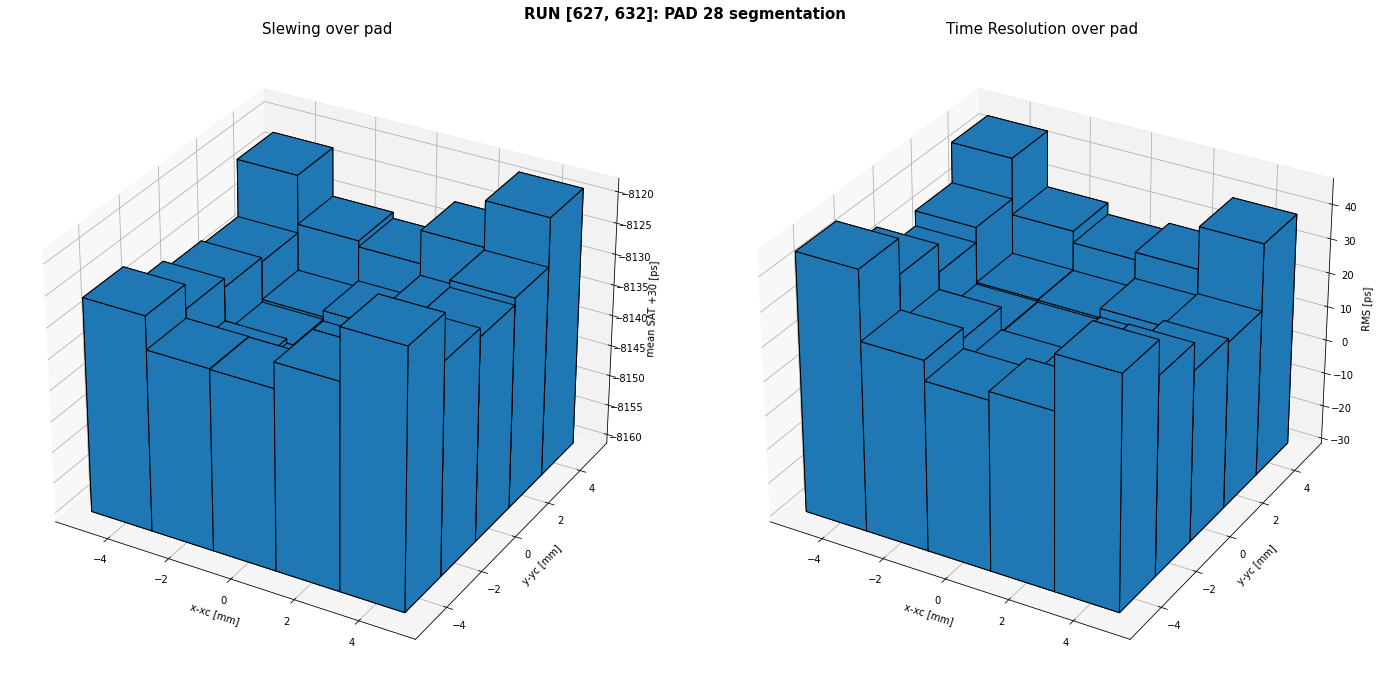

In [23]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'RUN {run}: PAD {pad_name[index]} segmentation', fontsize=15, fontweight='bold')

width = depth =step

ax1.bar3d(pad_seed[:,0], pad_seed[:,1], pad_seed[:,2].mean(), width, depth ,
          pad_seed[:,2]-pad_seed[:,2].mean()+30, shade=False, 
          edgecolor = 'black')

ax1.set_xlabel('x-xc [mm]')
ax1.set_ylabel('y-yc [mm]')
ax1.set_zlabel('mean SAT +30 [ps]')
ax1.set_title('Slewing over pad', fontsize=15)


ax2.bar3d(pad_seed[:,0], pad_seed[:,1], -30, width, depth,pad_seed[:,3]+30, shade=False, 
          edgecolor = 'black')

ax2.set_xlabel('x-xc [mm]')
ax2.set_ylabel('y-yc [mm]')
ax2.set_zlabel('RMS [ps]')
ax2.set_title('Time Resolution over pad', fontsize=15)

plt.show()

In [11]:
def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]

def slew_resol(sat,x, len_xbin=200,t_out_of_range=200):   
    d = {'sat':sat,'x':x}
    t_fun_x = pd.DataFrame(data=d)

    # sort
    t_fun_x.sort_values(by=['x'], inplace=True)
    #print('number of valid events ',len(t_fun_x))
    #binning
    num_points = round(len(t_fun_x)/len_xbin)

    arr = np.empty((0,7))
    for j in range(num_points):
        start =j*len_xbin
        end = (j+1)*len_xbin
        if(end>len(t_fun_x)):
            end = len(t_fun_x)
        
        x = t_fun_x.iloc[start:end,1].values
        t = t_fun_x.iloc[start:end,0].values
        mean = np.average(t,weights = np.abs(1/(t-t.mean())))
        t = t[np.abs(t-mean)<=t_out_of_range] # to cut times waaay out of range
        if(len(t)==0):
            print('zero left')
            continue

        xbin_hist = ROOT.TH1F(""," ", 100,t.mean()-5*t.std(),t.mean()+5*t.std());
        xbin_hist.FillN(len(t),t,np.ones(len(t)))
        result = xbin_hist.Fit('gaus','QS')
        arr = np.append(arr,
                        np.array([[x.mean() , np.abs(x[0]-x.mean()), np.abs(x[-1]-x.mean()),
                                  result.Parameter(1), result.ParError(1), result.Parameter(2),result.ParError(2)]]),
                        axis = 0)
    
    return arr

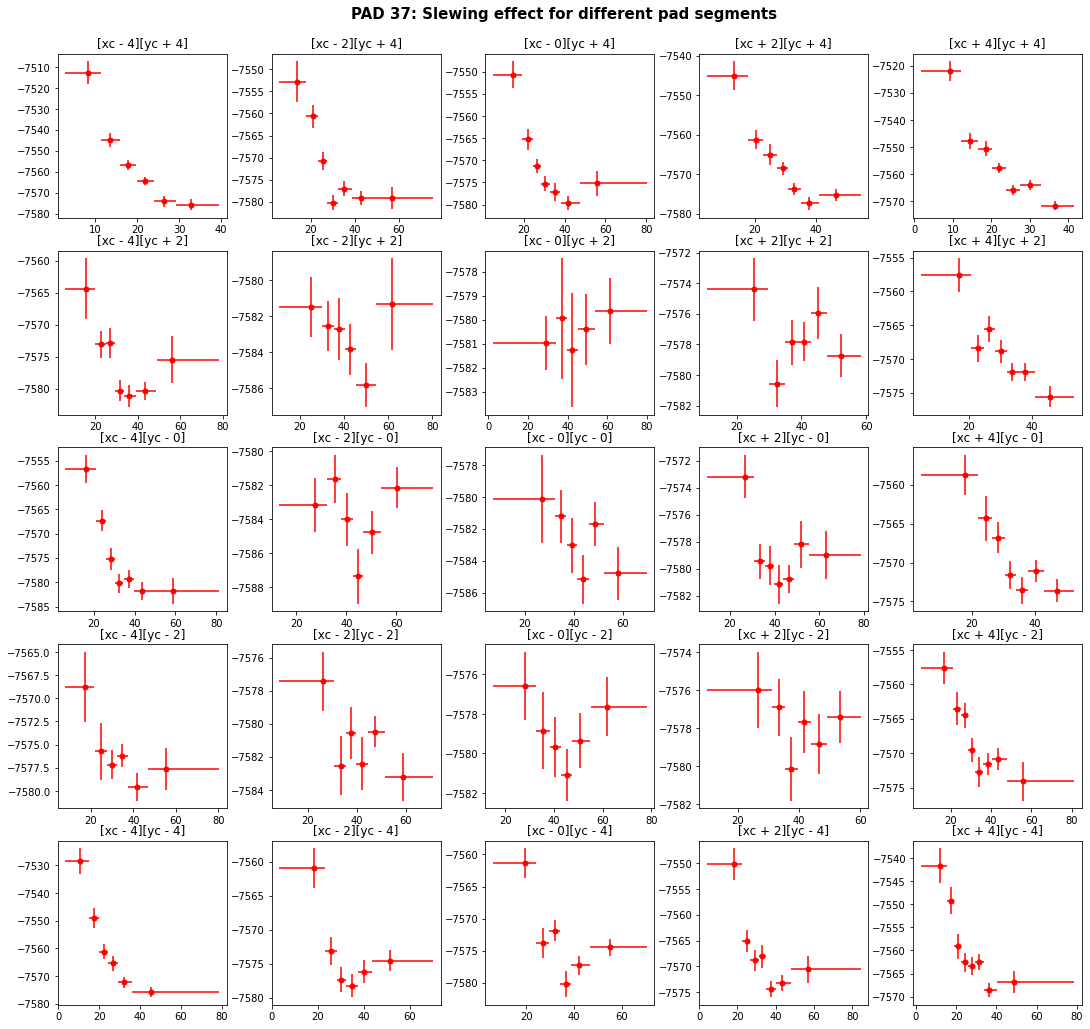

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [12]:
fig,axes = plt.subplots(5,5,figsize=(15,15));
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'PAD {pad_name[index]}: Slewing effect for different pad segments', fontsize=15, fontweight='bold')

slew = [[None] * 5 for i in range(5)]

for i,xstep in enumerate(range(-5,5,step)):
    for j,ystep in enumerate(range(-5,5,step)):
    
        sat = sat_hist[i][j].sat
        q = data.take(sat.index)[mm_qall]
    
        slew[i][j] = slew_resol(sat,q,len_xbin=200)

        ax = axes[4-j,i]
        ax.errorbar(slew[i][j][:,0],slew[i][j][:,3], yerr =slew[i][j][:,4] ,xerr=[slew[i][j][:,1],slew[i][j][:,2]],
                    fmt='o', markersize=5.,color =color[index] )
        
        xsign = '+' if np.sign(xstep)==1 else '-'
        ysign = '+' if np.sign(ystep)==1 else '-'
        ax.set_title(f'[xc {xsign} {np.abs(xstep+1)}][yc {ysign} {np.abs(ystep+1)}]')
plt.show()

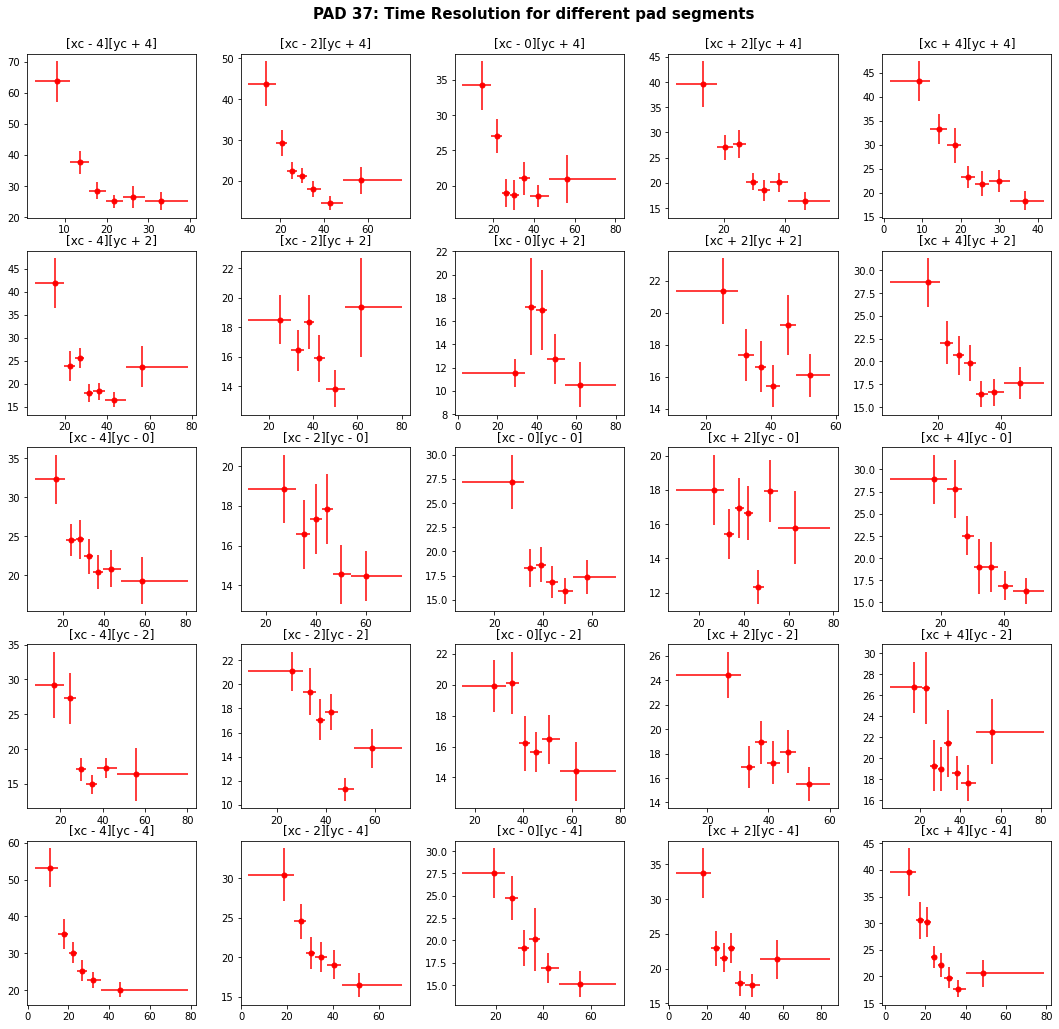

In [13]:
fig,axes = plt.subplots(5,5,figsize=(15,15));
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'PAD {pad_name[index]}: Time Resolution for different pad segments', fontsize=15, fontweight='bold')

for i,xstep in enumerate(range(-5,5,step)):
    for j,ystep in enumerate(range(-5,5,step)):
        
        ax = axes[4-j,i]
        ax.errorbar(slew[i][j][:,0],slew[i][j][:,5], yerr =slew[i][j][:,6] ,xerr=[slew[i][j][:,1],slew[i][j][:,2]],
                    fmt='o', markersize=5.,color =color[index] )
        
        xsign = '+' if np.sign(xstep)==1 else '-'
        ysign = '+' if np.sign(ystep)==1 else '-'
        ax.set_title(f'[xc {xsign} {np.abs(xstep+1)}][yc {ysign} {np.abs(ystep+1)}]')
plt.show()

In [14]:
# to store a file
#with open(f'/home/evridiki/Desktop/JULY_RUNS/for_tzamaria/pad{pad}_segment{xstep+1,ystep+1}.txt', 'w') as f:
 #    np.savetxt(f,slew[i][j])